# Кластеризация: K-Means и DBSCAN + мини-проект “Активные клиенты”

---

## Что такое кластеризация?
**Кластеризация** — это задача машинного обучения **без учителя**, где мы:
- не знаем правильных ответов заранее,
- но хотим **разделить объекты на группы** по похожести.

Пример:
- клиенты с похожим поведением покупки
- города с похожим уровнем преступности
- изображения с похожими характеристиками
- товары с похожими отзывами

---

## Что вы сделаете сегодня
✅ сгенерируете “датасет клиентов” (как в CRM)  
✅ сделаете минимальный анализ (EDA)  
✅ подготовите признаки и масштабирование  
✅ обучите **K-Means** (и выберете K)  
✅ попробуете **DBSCAN** (кластеры + “выбросы”)  
✅ интерпретируете кластеры и составите “план продаж”  
✅ закрепите всё на **10 заданиях**

In [2]:
# Если запускаете локально и чего-то нет:
# !pip install pandas numpy scikit-learn matplotlib seaborn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

np.random.seed(42)
sns.set_style("whitegrid")
print("Ready ✅")

Ready ✅


# 1) Интуиция кластеризации

Представьте, что у нас есть точки на плоскости — клиенты.

- Если две точки близко друг к другу → клиенты похожи.
- Если далеко → клиенты разные.

Кластеризация — это попытка **разбить точки на группы**, чтобы:
- внутри группы объекты были похожи
- между группами — отличались

⚠️ В отличие от классификации, **нет правильных меток**.
Мы сами выбираем, как интерпретировать группы.

---

## Где это используется в продажах?
- “Премиальные” клиенты
- “Стабильно покупающие”
- “Потерянные” (давно не покупали)
- “Новые”
- “Охотники за скидками”


# 2) Данные: “клиенты для продаж” (учебная CRM-таблица)

В реальной жизни вы бы взяли таблицу из базы или CRM.  
Но на уроке мы **сгенерируем** маленький, понятный датасет.

## Какие признаки возьмём?
- **recency_days**: сколько дней прошло с последней покупки (меньше = активнее)
- **frequency_30d**: сколько покупок за последние 30 дней
- **monetary_30d**: сколько денег потратил за последние 30 дней
- **avg_check**: средний чек
- **tenure_months**: сколько месяцев клиент с нами (стаж)

Это похоже на классический подход **RFM**:
- R = Recency
- F = Frequency
- M = Monetary


In [3]:
# Сгенерируем несколько “типов” клиентов (чтобы кластеризация была осмысленной)

vip = pd.DataFrame({
    "recency_days": np.random.normal(2, 2, size=120).clip(0, 20),
    "frequency_30d": np.random.normal(10, 2, size=120).clip(1, 25),
    "monetary_30d": np.random.normal(450, 80, size=120).clip(80, 1000),
    "avg_check": np.random.normal(70, 15, size=120).clip(10, 200),
    "tenure_months": np.random.normal(28, 10, size=120).clip(1, 60),
})

active = pd.DataFrame({
    "recency_days": np.random.normal(6, 4, size=260).clip(0, 30),
    "frequency_30d": np.random.normal(5, 2, size=260).clip(1, 15),
    "monetary_30d": np.random.normal(160, 50, size=260).clip(20, 400),
    "avg_check": np.random.normal(35, 10, size=260).clip(5, 120),
    "tenure_months": np.random.normal(18, 8, size=260).clip(1, 60),
})

newcomers = pd.DataFrame({
    "recency_days": np.random.normal(8, 6, size=220).clip(0, 40),
    "frequency_30d": np.random.normal(2, 1, size=220).clip(1, 6),
    "monetary_30d": np.random.normal(60, 25, size=220).clip(5, 200),
    "avg_check": np.random.normal(25, 8, size=220).clip(5, 100),
    "tenure_months": np.random.normal(3, 2, size=220).clip(0.5, 12),
})

sleeping = pd.DataFrame({
    "recency_days": np.random.normal(50, 20, size=220).clip(10, 120),
    "frequency_30d": np.random.normal(1, 0.5, size=220).clip(0, 3),
    "monetary_30d": np.random.normal(20, 15, size=220).clip(0, 80),
    "avg_check": np.random.normal(18, 6, size=220).clip(2, 60),
    "tenure_months": np.random.normal(22, 12, size=220).clip(1, 60),
})

df = pd.concat([vip, active, newcomers, sleeping], ignore_index=True)

for col in df.columns:
    mask = np.random.rand(len(df)) < 0.02
    df.loc[mask, col] = np.nan

df.head()

,recency_days,frequency_30d,monetary_30d,avg_check,tenure_months
0,2.993428,11.582064,386.598341,77.790198,26.720824
1,1.723471,8.181225,440.821085,92.991084,18.444596
2,3.295377,12.805589,490.398982,68.368598,NaN
3,5.046060,7.196298,519.260416,76.025676,30.034636
4,1.531693,11.173714,353.976287,80.352160,20.436493


# 3) Мини-EDA

Смотрим таблицу и пропуски.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency_days   803 non-null    float64
 1   frequency_30d  807 non-null    float64
 2   monetary_30d   808 non-null    float64
 3   avg_check      802 non-null    float64
 4   tenure_months  801 non-null    float64
dtypes: float64(5)
memory usage: 32.2 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_days,803.0,17.158719,21.455431,0.000000,3.329056,7.890390,18.599079,87.753753
frequency_30d,807.0,4.053514,3.389014,0.000000,1.323768,2.686318,6.226292,17.705463
monetary_30d,808.0,137.748860,146.345458,0.000000,31.888061,80.697245,180.755204,620.642670
avg_check,802.0,33.311272,19.659266,4.103137,19.669627,28.201226,40.517465,116.183212
tenure_months,801.0,16.496984,11.882840,0.500000,4.628304,16.718938,25.174715,59.824681


In [6]:
df.isna().sum().sort_values(ascending=False)

,0
tenure_months,19
avg_check,18
recency_days,17
frequency_30d,13
monetary_30d,12


In [7]:
# Заполним пропуски медианой
df_filled = df.copy()
for col in df_filled.columns:
    df_filled[col] = df_filled[col].fillna(df_filled[col].median())

df_filled.isna().sum().sum()

np.int64(0)

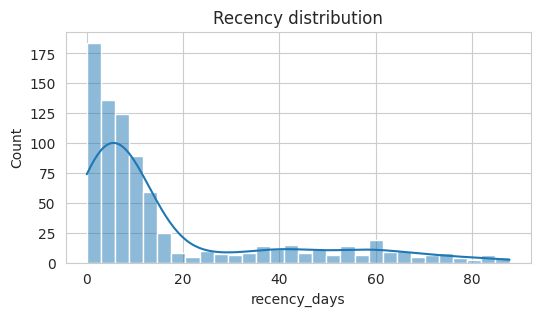

In [8]:
plt.figure(figsize=(6,3))
sns.histplot(df_filled["recency_days"], bins=30, kde=True)
plt.title("Recency distribution")
plt.xlabel("recency_days")
plt.grid(True)
plt.show()

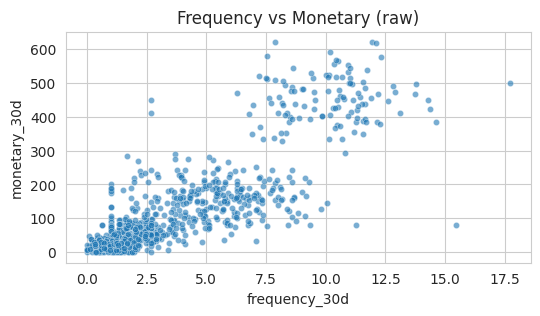

In [9]:
plt.figure(figsize=(6,3))
sns.scatterplot(data=df_filled, x="frequency_30d", y="monetary_30d", s=20, alpha=0.6)
plt.title("Frequency vs Monetary (raw)")
plt.grid(True)
plt.show()

# 4) Масштабирование (StandardScaler)

Важно, потому что кластеризация = расстояния.


In [10]:
features = ["recency_days", "frequency_30d", "monetary_30d", "avg_check", "tenure_months"]
X = df_filled[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled mean:", X_scaled.mean(axis=0).round(3))
print("Scaled std :", X_scaled.std(axis=0).round(3))

Scaled mean: [ 0.  0. -0.  0. -0.]
Scaled std : [1. 1. 1. 1. 1.]


# 5) K-Means

Выбор K через Elbow + Silhouette.


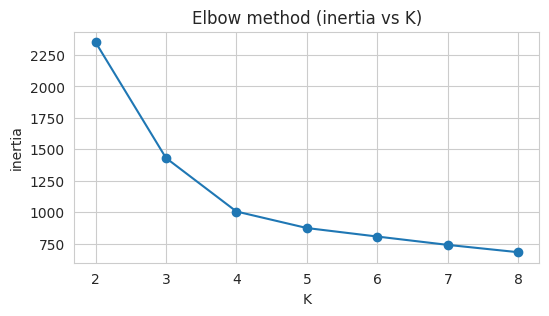

In [11]:
inertias = []
Ks = range(2, 9)

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,3))
plt.plot(list(Ks), inertias, marker="o")
plt.title("Elbow method (inertia vs K)")
plt.xlabel("K")
plt.ylabel("inertia")
plt.grid(True)
plt.show()

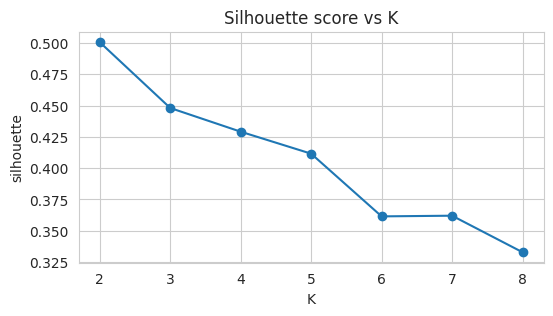

,K,silhouette
0,2,0.500630
1,3,0.448059
2,4,0.429117
3,5,0.411538
4,6,0.361438
5,7,0.361974
6,8,0.332785


In [12]:
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,3))
plt.plot(list(Ks), sil_scores, marker="o")
plt.title("Silhouette score vs K")
plt.xlabel("K")
plt.ylabel("silhouette")
plt.grid(True)
plt.show()

pd.DataFrame({"K": list(Ks), "silhouette": sil_scores})

In [13]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_km = kmeans.fit_predict(X_scaled)

df_km = df_filled.copy()
df_km["cluster_kmeans"] = cluster_km

df_km["cluster_kmeans"].value_counts().sort_index()

,count
cluster_kmeans,
0,251
1,183
2,116
3,270


In [14]:
df_km.groupby("cluster_kmeans")[features].mean().round(1)

,recency_days,frequency_30d,monetary_30d,avg_check,tenure_months
cluster_kmeans,,,,,
0,6.1,5.5,160.5,36.1,19.1
1,51.8,1.1,21.2,17.5,24.0
2,2.1,10.1,449.3,70.5,26.9
3,9.8,2.1,59.2,25.1,4.5


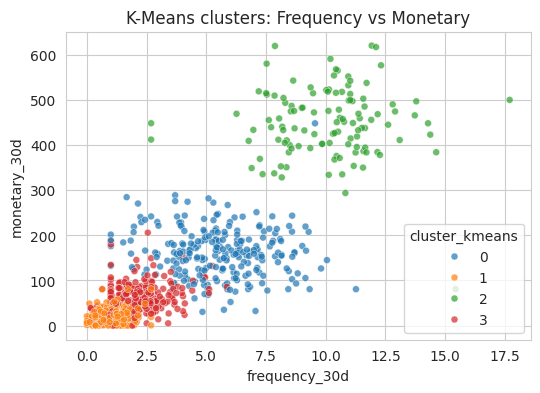

In [15]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df_km, x="frequency_30d", y="monetary_30d",
    hue="cluster_kmeans", palette="tab10", s=25, alpha=0.7
)
plt.title("K-Means clusters: Frequency vs Monetary")
plt.grid(True)
plt.show()

# 6) DBSCAN

Находит кластеры по плотности + выделяет шум (-1).


In [16]:
db = DBSCAN(eps=0.9, min_samples=12)
cluster_db = db.fit_predict(X_scaled)

df_db = df_filled.copy()
df_db["cluster_dbscan"] = cluster_db

df_db["cluster_dbscan"].value_counts().sort_index()

,count
cluster_dbscan,
-1,44
0,82
1,694


In [17]:
noise_rate = (df_db["cluster_dbscan"] == -1).mean()
print("Noise rate:", round(noise_rate, 3))

Noise rate: 0.054


In [18]:
df_db_no_noise = df_db[df_db["cluster_dbscan"] != -1]
df_db_no_noise.groupby("cluster_dbscan")[features].mean().round(1)

,recency_days,frequency_30d,monetary_30d,avg_check,tenure_months
cluster_dbscan,,,,,
0,2.3,10.0,445.1,70.1,26.5
1,19.3,3.0,85.0,26.9,14.5


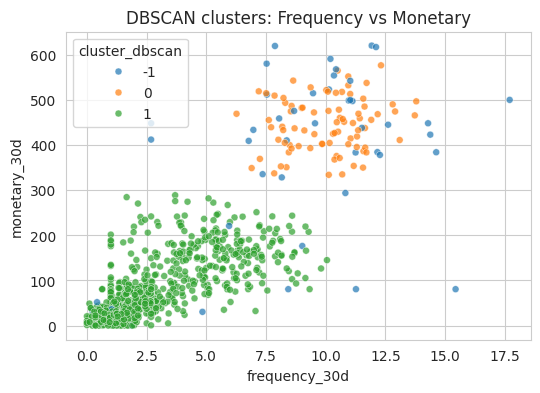

In [19]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df_db, x="frequency_30d", y="monetary_30d",
    hue="cluster_dbscan", palette="tab10", s=25, alpha=0.7
)
plt.title("DBSCAN clusters: Frequency vs Monetary")
plt.grid(True)
plt.show()

# 7) Бизнес-задача: “активные клиенты” для продаж

Сделаем простой activity_score и найдём лучший кластер.


In [20]:
df_km["activity_score"] = (
    df_km["frequency_30d"] * 1.0 +
    df_km["monetary_30d"] * 0.01 +
    (-df_km["recency_days"]) * 0.2
)

df_km.groupby("cluster_kmeans")["activity_score"].mean().sort_values(ascending=False).round(2)

,activity_score
cluster_kmeans,
2,14.17
0,5.85
3,0.73
1,-9.09


In [21]:
best_cluster = df_km.groupby("cluster_kmeans")["activity_score"].mean().idxmax()
print("Best cluster:", best_cluster)

df_km["is_active_segment"] = (df_km["cluster_kmeans"] == best_cluster).astype(int)
df_km["is_active_segment"].value_counts()

Best cluster: 2


,count
is_active_segment,
0,704
1,116


In [22]:
df_km.groupby("is_active_segment")[features].mean().round(1)

,recency_days,frequency_30d,monetary_30d,avg_check,tenure_months
is_active_segment,,,,,
0,19.4,3.0,85.4,27.1,14.8
1,2.1,10.1,449.3,70.5,26.9


---
# Итоги занятия
✅ K-Means и DBSCAN + сегментация активных клиентов + визуализация


# 10 заданий (код с пропусками)

Заполняйте `_____`.


## Задание 1

**Задание:** Посчитайте пропуски по колонкам.  


In [ ]:
missing = df._____
missing.sort_values(ascending=False)

## Задание 2

**Задание:** Заполните пропуски медианой в цикле.  


In [ ]:
df_fill = df.copy()
for col in df_fill.columns:
    df_fill[col] = df_fill[col].fillna(df_fill[col]._____)
df_fill.isna().sum()

## Задание 3

**Задание:** Сделайте StandardScaler и X_scaled.  


In [ ]:
from sklearn.preprocessing import StandardScaler
features = ["recency_days", "frequency_30d", "monetary_30d", "avg_check", "tenure_months"]
X = df_fill[features].values

scaler = StandardScaler()
X_scaled = scaler._____(X)
print(X_scaled.shape)

## Задание 4

**Задание:** Обучите KMeans K=4 и получите labels.


In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=_____, random_state=42, n_init=10)
labels = km._____(X_scaled)
pd.Series(labels).value_counts().sort_index()

## Задание 5

**Задание:** Посчитайте silhouette score.


In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(_____, _____)
print(round(score, 3))

## Задание 6

**Задание:** Добавьте кластер в df и посчитайте средние.  


In [ ]:
df_k = df_fill.copy()
df_k["cluster"] = _____
df_k.groupby("_____")[features].mean().round(1)

## Задание 7

**Задание:** Нарисуйте scatterplot по кластерам.  


In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_k, x="frequency_30d", y="monetary_30d", hue="_____", s=25, alpha=0.7)
plt.grid(True)
plt.show()

## Задание 8

**Задание:** DBSCAN и доля шума (-1).


In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=_____, min_samples=_____)
labels_db = db.fit_predict(X_scaled)

noise_rate = (labels_db == _____).mean()
print(round(noise_rate, 3))

## Задание 9

**Задание:** Сделайте activity_score и найдите лучший кластер.


In [ ]:
df_k["activity_score"] = (
    df_k["frequency_30d"] * _____ +
    df_k["monetary_30d"] * _____ +
    (-df_k["recency_days"]) * _____
)

best_cluster = df_k.groupby("_____")["activity_score"].mean().idxmax()
print(best_cluster)

## Задание 10

**Задание:** Сделайте флаг активного сегмента.


In [ ]:
df_k["is_active_segment"] = (df_k["cluster"] == _____).astype(int)
df_k["is_active_segment"].value_counts()
